<a href="https://colab.research.google.com/github/elzurdo/rock-paper-scissors/blob/master/rock_paper_scissors_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [43]:
ls

data/  sample_data/


In [0]:
from pathlib import Path

path = Path('data')
path_train = path / 'train'

try:
  path.mkdir()
  print(f'Made {path.name}')
except:
  None

try:
  path_train.mkdir()
  print(f'Made {path_train.name}')
except:
  None

In [50]:
from IPython.display import Image
import matplotlib.pyplot as plt

classes = ['rock', 'paper', 'scissors']

n_shots = 3
file_type = '.jpg'

for item in classes: 
  path_class = path_train / item

  try:
    path_class.mkdir()
    print(f'Made {path_class.name}', end="\r")
  except:
    None

  for idx in range(n_shots):
    print(f'{item}')
    filename = path_class / f'{idx + 1:02.0f}{file_type}'
    print(filename, end="\r")

    try:
      filename = take_photo(filename)
      #print('Saved to {}'.format(filename))
      
      # Show the image which was just taken.
      #display(Image(str(filename)))
      #image = imageio.imread(filename)
    except Exception as err:
        # Errors will be thrown if the user does not have a webcam or if they do not
        # grant the page permission to access it.
        print(str(err))


rock


<IPython.core.display.Javascript object>

rock


<IPython.core.display.Javascript object>

rock


<IPython.core.display.Javascript object>

paper


<IPython.core.display.Javascript object>

paper


<IPython.core.display.Javascript object>

paper


<IPython.core.display.Javascript object>

scissors


<IPython.core.display.Javascript object>

scissors


<IPython.core.display.Javascript object>

scissors


<IPython.core.display.Javascript object>

In [52]:
ls data/train

paper/  rock/  scissors/


# Augment

In [0]:
from fastai.vision import (ImageDataBunch, get_transforms, models, error_rate, 
                           cnn_learner, ClassificationInterpretation, imagenet_stats,open_image)

In [0]:
path_train_augmented = path / 'train_augmented'

try:
    path_train_augmented.mkdir()
except:
    None


In [55]:
ls data

train/  train_augmented/


In [56]:
def get_image(file_): 
    return open_image(file_)

def augment_image(file_, tfms, **kwargs):
    return get_image(file_).apply_tfms(tfms[0], **kwargs)

tfms = get_transforms(max_rotate=10., do_flip=False, 
                             flip_vert=False, p_affine=1., max_zoom=1.2, max_warp=0.)
len(tfms)

2

In [57]:
ls data

train/  train_augmented/


In [58]:
n_augmentations = 20

image_type = '.jpg'

for path_ in path_train.iterdir():
    path_train_augmented_class = path_train_augmented / path_.name
    print(path_train_augmented_class)
    
    try:
        path_train_augmented_class.mkdir()    
    except:
        None
    
    for image_infile in path_.iterdir():
        print(image_infile)
         
        suffix_start = image_infile.parts[-1].split(f'{image_type}')[0]
        for idx in range(n_augmentations):
            image_new = augment_image(image_infile, tfms, padding_mode='border')
            image_outfile = path_train_augmented_class / f'{suffix_start}_{idx:03.0f}{image_type}'
            image_new.save(image_outfile)
            #print(outfile)

data/train_augmented/paper
data/train/paper/02.jpg
data/train/paper/03.jpg
data/train/paper/01.jpg
data/train_augmented/scissors
data/train/scissors/02.jpg
data/train/scissors/03.jpg
data/train/scissors/01.jpg
data/train_augmented/rock
data/train/rock/02.jpg
data/train/rock/03.jpg
data/train/rock/01.jpg


In [59]:
import numpy as np

batch_size = int(n_augmentations)
tfms_train = None

valid_pct = 0.2

np.random.seed(1)
data = ImageDataBunch.from_folder(path, train=f"train_augmented", valid_pct=valid_pct,
                                  bs=batch_size, ds_tfms=tfms_train, size=224, 
                                  num_workers=4).normalize(imagenet_stats)

data.classes[:4], data.c, len(data.train_ds), len(data.valid_ds)

(['paper', 'rock', 'scissors'], 3, 152, 37)

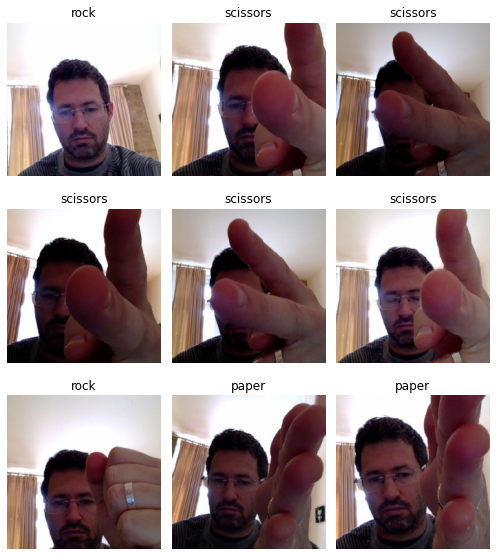

In [60]:
data.show_batch(rows=3, figsize=(7,8))

In [61]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [62]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.922035,0.093847,0.000000,00:04
1,0.439160,0.001578,0.000000,00:04
2,0.273399,0.000203,0.000000,00:04
3,0.190254,0.000080,0.000000,00:04


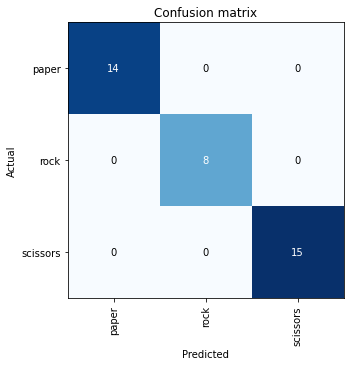

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5, 5))

<IPython.core.display.Javascript object>

Saved to photo.jpg


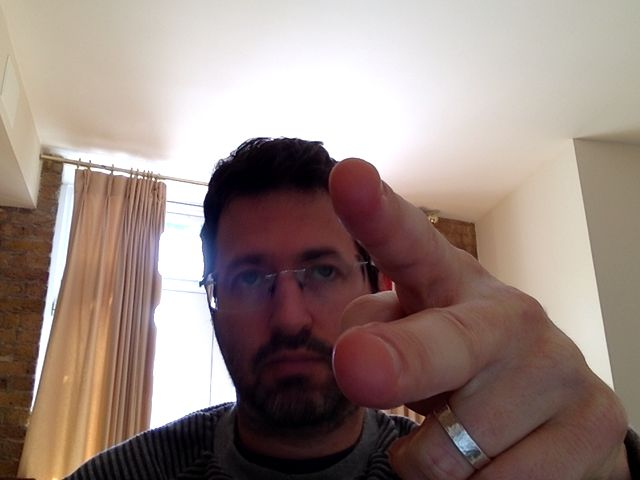

scissors
[('paper', 10.6), ('rock', 5.2), ('scissors', 84.2)]


In [68]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

img = open_image(filename)

pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)
print(list(zip(data.classes, map(lambda x: np.round(x * 100,1), outputs.detach().numpy())   )))